# SAS Viya Python Client Demo: A Simple Pipeline Using Decision Tree to Analyze Survival Data From the Titanic

## Import packages:   SAS Wrapper for Analytic Transfer and Opensource Libraries

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from swat import *

## Connect to CAS with the port number

In [4]:
s = CAS('centis', 5570,'sasdemo', 'SASpw1')
print(s);

CAS('centis', 5570, 'sasdemo', protocol='cas', name='py-session-1', session='be121917-9008-fe48-b336-f2c5848702be')


In [5]:
s.loadactionset(actionset="dataStep")

NOTE: Added action set 'dataStep'.


[actionset]

 'dataStep'

+ Elapsed: 0.000378s, sys: 0.000357s, mem: 0.194mb

## Ask for CAS server status

In [6]:
s.builtins.serverStatus()

NOTE: Grid node action status report: 1 nodes, 11 total actions executed.


[About]

 {'CAS': 'Cloud Analytic Services',
  'Version': '3.04',
  'VersionLong': 'V.03.04M0P07112018',
  'Copyright': 'Copyright © 2014-2018 SAS Institute Inc. All Rights Reserved.',
  'ServerTime': '2018-11-12T14:21:12Z',
  'System': {'Hostname': 'centis',
   'OS Name': 'Linux',
   'OS Family': 'LIN X64',
   'OS Release': '3.10.0-862.14.4.el7.x86_64',
   'OS Version': '#1 SMP Wed Sep 26 15:12:11 UTC 2018',
   'Model Number': 'x86_64',
   'Linux Distribution': 'CentOS Linux release 7.5.1804 (Core)'},
  'license': {'site': 'The Room VDMML and ESP',
   'siteNum': 70180938,
   'expires': '05Nov2019:00:00:00',
   'gracePeriod': 45,
   'warningPeriod': 45,
   'maxCPUs': 9999}}

[server]

 Server Status
 
    nodes  actions
 0      1       11

[nodestatus]

 Node Status
 
                    name        role  uptime  running  stalled
 0  centis.example.local  controller  10.362        0        0

+ Elapsed: 0.000751s, sys: 0.000727s, mem: 0.295mb

In [7]:
s.invoke('echo', a=[1, 2, 3], b={'one':'x', 'two':'y', 'three':'z'})

CAS('centis', 5570, 'sasdemo', protocol='cas', name='py-session-1', session='be121917-9008-fe48-b336-f2c5848702be')

## Load the decision tree action set

In [8]:
s.loadactionset('decisionTree')

NOTE: Added action set 'decisionTree'.


[actionset]

 'decisionTree'

+ Elapsed: 0.0888s, user: 0.00891s, sys: 0.0433s, mem: 0.195mb

In [9]:
s.tableinfo()

NOTE: No tables are available in caslib CASUSER(sasdemo) of Cloud Analytic Services.


+ Elapsed: 0.00264s, user: 0.00201s, sys: 0.000582s, mem: 0.274mb

## Load data sets from Amazon S3 into CAS

In [10]:
out = s.upload("http://s3.amazonaws.com/assets.datacamp.com/course/Kaggle/train.csv",
               casout=dict(name='train',replace = True))
out = s.upload("http://s3.amazonaws.com/assets.datacamp.com/course/Kaggle/test.csv",
               casout=dict(name='test',replace = True))

NOTE: Cloud Analytic Services made the uploaded file available as table TRAIN in caslib CASUSER(sasdemo).
NOTE: The table TRAIN has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table TEST in caslib CASUSER(sasdemo).
NOTE: The table TEST has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.


In [10]:
out = s.upload("TitanicTrain.csv",
               casout=dict(name='train', replace=True))
out = s.upload("TitanicTest.csv",
               casout=dict(name='test', replace=True))

NOTE: Cloud Analytic Services made the uploaded file available as table TRAIN in caslib CASUSER(sasdemo).
NOTE: The table TRAIN has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table TEST in caslib CASUSER(sasdemo).
NOTE: The table TEST has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.


In [11]:
s.tableinfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,TRAIN,891,12,0,utf-8,2018-11-12T15:33:28+01:00,2018-11-12T15:33:28+01:00,2018-11-12T15:33:28+01:00,UTF8,1.857652e+09,...,0,0,0,,,0,sasdemo,,2018-11-12T15:33:27+01:00,1.857652e+09
1,TEST,418,11,0,utf-8,2018-11-12T15:33:28+01:00,2018-11-12T15:33:28+01:00,2018-11-12T15:33:28+01:00,UTF8,1.857652e+09,...,0,0,0,,,0,sasdemo,,2018-11-12T15:33:27+01:00,1.857652e+09


## Create an Instace of Cas Table Object

In [12]:
dtrain = s.CASTable("TRAIN")
dtest = s.CASTable("TEST")

## Data Exploration

### 1. Get to know your data (what is target? what are variables?)

In [13]:
dtrain.columninfo()

,Column,ID,Type,RawLength,FormattedLength,NFL,NFD
0,PassengerId,1,double,8,12,0,0
1,Survived,2,double,8,12,0,0
2,Pclass,3,double,8,12,0,0
3,Name,4,varchar,82,82,0,0
4,Sex,5,varchar,6,6,0,0
5,Age,6,double,8,12,0,0
6,SibSp,7,double,8,12,0,0
7,Parch,8,double,8,12,0,0
8,Ticket,9,varchar,18,18,0,0
9,Fare,10,double,8,12,0,0


In [14]:
dtrain.fetch(to=10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.0,3.0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,,S
1,2.0,1.0,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C
2,3.0,1.0,3.0,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,,S
3,4.0,1.0,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S
4,5.0,0.0,3.0,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,,S
5,6.0,0.0,3.0,"Moran, Mr. James",male,NaN,0.0,0.0,330877,8.4583,,Q
6,7.0,0.0,1.0,"McCarthy, Mr. Timothy J",male,54.0,0.0,0.0,17463,51.8625,E46,S
7,8.0,0.0,3.0,"Palsson, Master. Gosta Leonard",male,2.0,3.0,1.0,349909,21.0750,,S
8,9.0,1.0,3.0,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0.0,2.0,347742,11.1333,,S
9,10.0,1.0,2.0,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1.0,0.0,237736,30.0708,,C


In [15]:
dtrain.distinct()

,Column,NDistinct,NMiss,Trunc
0,PassengerId,891.0,0.0,0.0
1,Survived,2.0,0.0,0.0
2,Pclass,3.0,0.0,0.0
3,Name,891.0,0.0,0.0
4,Sex,2.0,0.0,0.0
5,Age,89.0,177.0,0.0
6,SibSp,7.0,0.0,0.0
7,Parch,7.0,0.0,0.0
8,Ticket,681.0,0.0,0.0
9,Fare,248.0,0.0,0.0


In [16]:
outSumm = dtrain.summary()
outSumm

,Column,Min,Max,N,NMiss,Mean,Sum,Std,StdErr,Var,USS,CSS,CV,TValue,ProbT,Skewness,Kurtosis
0,PassengerId,1.00,891.0000,891.0,0.0,446.000000,397386.0000,257.353842,8.621678,66231.000000,2.361797e+08,5.894559e+07,57.702655,51.730069,1.766713e-270,-6.300776e-17,-1.200000
1,Survived,0.00,1.0000,891.0,0.0,0.383838,342.0000,0.486592,0.016301,0.236772,3.420000e+02,2.107273e+02,126.770139,23.546257,1.117856e-95,4.785234e-01,-1.775005
2,Pclass,1.00,3.0000,891.0,0.0,2.308642,2057.0000,0.836071,0.028009,0.699015,5.371000e+03,6.221235e+02,36.214851,82.423709,0.000000e+00,-6.305479e-01,-1.280015
3,Age,0.42,80.0000,714.0,177.0,29.699118,21205.1700,14.526497,0.543640,211.019125,7.802315e+05,1.504566e+05,48.912219,54.630068,4.910174e-257,3.891078e-01,0.178274
4,SibSp,0.00,8.0000,891.0,0.0,0.523008,466.0000,1.102743,0.036943,1.216043,1.326000e+03,1.082278e+03,210.846437,14.157044,3.481639e-41,3.695352e+00,17.880420
5,Parch,0.00,6.0000,891.0,0.0,0.381594,340.0000,0.806057,0.027004,0.649728,7.080000e+02,5.782581e+02,211.234407,14.131042,4.707998e-41,2.749117e+00,9.778125
6,Fare,0.00,512.3292,891.0,0.0,32.204208,28693.9493,49.693429,1.664792,2469.436846,3.121865e+06,2.197799e+06,154.307253,19.344277,7.255925e-70,4.787317e+00,33.398141


### 2. Gender vs Survived

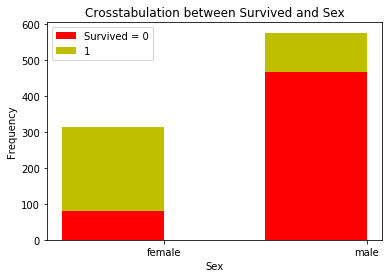

In [17]:
xtab_out = dtrain.crosstab(row = "Survived", col = "Sex")
survived0=xtab_out["Crosstab"].loc[0][1:3]
survived1=xtab_out["Crosstab"].loc[1][1:3]
ind = np.arange(2)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, survived0, width, color='r')
p2 = plt.bar(ind, survived1, width, color='y', bottom=survived0)

plt.ylabel('Frequency')
plt.xlabel('Sex')
plt.title('Crosstabulation between Survived and Sex')
plt.xticks(ind + width/2., ('female', 'male'))
plt.legend((p1[0], p2[0]), ('Survived = 0', '1'), loc=2)

*__Survival rate of women is much higher than that of men. Good job gentlemen!__*

### Understand CASResults Object

In [18]:
type(xtab_out)

swat.cas.results.CASResults

In [19]:
type(xtab_out["Crosstab"])

swat.dataframe.SASDataFrame

In [20]:
type(xtab_out["Crosstab"].loc[0])

pandas.core.series.Series

### 3. Pclass vs Survived

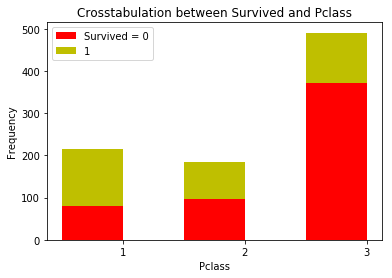

In [21]:
xtab_out = dtrain.crosstab(row = "Survived", col = "Pclass")
survived0=xtab_out["Crosstab"].loc[0][1:4]
survived1=xtab_out["Crosstab"].loc[1][1:4]
ind = np.arange(3)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, survived0, width, color='r')
p2 = plt.bar(ind, survived1, width, color='y', bottom=survived0)

plt.ylabel('Frequency')
plt.xlabel('Pclass')
plt.title('Crosstabulation between Survived and Pclass')
plt.xticks(ind + width/2., ('1', '2', '3'))
plt.legend((p1[0], p2[0]), ('Survived = 0', '1'), loc=2)

#### * Apparently, both Gender and Pclass are important variables regarding surival *

## Model Data Using Decision Tree

###  0. Do Feature Engineering

In [22]:
sasCode = 'if find(name, "master", 1, "it") then child =1;\n'
sasCode = sasCode + 'else if (not missing(age)) and (age <= 7) then child = 1;\n'
sasCode = sasCode + 'else child = 0;'
print(sasCode)
s.dataStep.runCode(code="data train_2; set train; "+sasCode+" run;")
#trainTbl2 = dtrain.datastep(sasCode,casout=dict(name='train_2', replace = True))
trainTbl2 = s.CASTable('train_2')
trainTbl2.columninfo()

if find(name, "master", 1, "it") then child =1;
else if (not missing(age)) and (age <= 7) then child = 1;
else child = 0;


,Column,ID,Type,RawLength,FormattedLength,NFL,NFD
0,PassengerId,1,double,8,12,0,0
1,Survived,2,double,8,12,0,0
2,Pclass,3,double,8,12,0,0
3,Name,4,varchar,82,82,0,0
4,Sex,5,varchar,6,6,0,0
5,Age,6,double,8,12,0,0
6,SibSp,7,double,8,12,0,0
7,Parch,8,double,8,12,0,0
8,Ticket,9,varchar,18,18,0,0
9,Fare,10,double,8,12,0,0


In [21]:
trainTbl2.fetch(to = 5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,child
0,1.0,0.0,3.0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,725.0,,S,0.0
1,2.0,1.0,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,712833.0,C85,C,0.0
2,3.0,1.0,3.0,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7925.0,,S,0.0
3,4.0,1.0,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,531.0,C123,S,0.0
4,5.0,0.0,3.0,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,805.0,,S,0.0


In [23]:
#testTbl = s.CASTable('test')
s.dataStep.runCode(code="data test_2; set test; "+sasCode+" run;")
#testTbl2 = testTbl.datastep(sasCode,casout=dict(name='test_2', replace = True))
testTbl2 = s.CASTable('test_2')
testTbl2.fetch(to = 5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,child
0,892.0,3.0,"Kelly, Mr. James",male,34.5,0.0,0.0,330911,7.8292,,Q,0.0
1,893.0,3.0,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1.0,0.0,363272,7.0000,,S,0.0
2,894.0,2.0,"Myles, Mr. Thomas Francis",male,62.0,0.0,0.0,240276,9.6875,,Q,0.0
3,895.0,3.0,"Wirz, Mr. Albert",male,27.0,0.0,0.0,315154,8.6625,,S,0.0
4,896.0,3.0,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1.0,1.0,3101298,12.2875,,S,0.0


###  1. Partition data on-the-fly

In [24]:
## random number generation ##

trainTbl2.compvars = "__partID__"
trainTbl2.comppgm = "call streaminit(_rankid_*1000+_threadid_);__partID__=rand('UNIFORM');"

out1 = s.table.partition(table = trainTbl2, outTable = {'name':'dat1','replace':True})
dat1 = s.CASTable('dat1')

dat1.fetch(to=3)




,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,child,__partID__
0,1.0,0.0,3.0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,,S,0.0,0.883866
1,2.0,1.0,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C,0.0,0.973821
2,3.0,1.0,3.0,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,,S,0.0,0.507583


### 2. Generate a list of predicators

In [25]:
df1 = s.columninfo("train_2")["ColumnInfo"]
df1

,Column,ID,Type,RawLength,FormattedLength,NFL,NFD
0,PassengerId,1,double,8,12,0,0
1,Survived,2,double,8,12,0,0
2,Pclass,3,double,8,12,0,0
3,Name,4,varchar,82,82,0,0
4,Sex,5,varchar,6,6,0,0
5,Age,6,double,8,12,0,0
6,SibSp,7,double,8,12,0,0
7,Parch,8,double,8,12,0,0
8,Ticket,9,varchar,18,18,0,0
9,Fare,10,double,8,12,0,0


In [25]:
varlist = df1["Column"][(df1["Column"]!="Survived") & (df1["Column"]!="PassengerId") & 
                        (df1["Column"]!="Cabin") & (df1["Column"]!="Ticket")].tolist()
varlist

['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'child']

### 3. Decision Tree Model Training

In [27]:
print('Decision tree training for training dataset...')
start_time = time.clock()

trainprop = 0.6
dat1.where = "__partID__ LE %F" % trainprop # data partition -- select 60% of data randomly as training data
dat1.varlist = varlist
dtreeout = s.dtreetrain(
    table = dat1,                                  # input data#
    inputs = varlist,                              # list of all predictors
    nominal = ['Survived','Pclass','SibSp','Parch','Child'],
    casout = table(name='dt_model1',replace=True), # generated similarity table # 
    target = 'Survived',                           # target variable #
    nbins = 20, maxlevel = 6, leafsize = 10,       # tree options # 
    varimp=True
)
print("Training time is " + str(time.clock()-start_time) + "s")
dat1.where = ""   # reset where clause
dat1.varlist = [] # reset varlist for dat1
dtreeout


Decision tree training for training dataset...


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


NameError: name 'varlist' is not defined

*Both Pclass and sex are important based on the variable importance from the tree model to predict the survival rate. This also agrees with the previous simple crosstab results.*

### 4. Model Assessment

In [28]:
# first score the validation data
dat1.where = "__partID__ GT %F" % trainprop # data partition -- select 40% of data randomly as validation data
score_out = s.dtreescore(
    table = dat1,                                    # Table for scoring #
    casout = table(name='dt_score',replace=True),   # Table stores the scoring results #
    model  = 'dt_model1',                           # Decison tree model #
    copyVars = {"Survived"},
    target = 'Survived', 
    assess = True
)

dat1.where = ""   # reset where clause
dat1.varlist = [] # reset varlist for dat1
score_out

ERROR: The file or path 'dt_model1' is not available in the file system.
ERROR: Table 'dt_model1' could not be loaded.
ERROR: Failure opening table 'dt_model1': A table could not be loaded.
ERROR: The action stopped due to errors.


+ Elapsed: 0.000165s, user: 0.807s, sys: 1.75s

In [30]:
dt_score = s.CASTable('dt_score')
dt_score.fetch(to = 5)

,Survived,_DT_PredName_,_DT_PredP_,_DT_PredLevel_,_LeafID_,_MissIt_,_NumNodes_,_NodeList0_,_NodeList1_,_NodeList2_,_NodeList3_,_NodeList4_,_NodeList5_,_DT_Level_,_DT_P_
0,0.0,0,0.878788,1.0,22.0,0.0,6.0,0.0,1.0,3.0,8.0,15.0,22.0,1,0.121212
1,0.0,0,0.878788,1.0,22.0,0.0,6.0,0.0,1.0,3.0,8.0,15.0,22.0,0,0.878788
2,1.0,1,1.000000,0.0,11.0,0.0,4.0,0.0,2.0,5.0,11.0,NaN,NaN,1,1.000000
3,1.0,1,1.000000,0.0,11.0,0.0,4.0,0.0,2.0,5.0,11.0,NaN,NaN,0,0.000000
4,1.0,1,0.978723,0.0,25.0,0.0,6.0,0.0,2.0,5.0,12.0,17.0,25.0,1,0.978723


In [48]:
#second, LIFT and ROC
s.builtins.loadActionSet("percentile")


dt_score.computedVars=["P1", "P0"] # 3
dt_score.computedVarsProgram='''
    if '1' eq strip(_DT_PredName_) then do;
        P1 = _DT_PredP_;
        P0 = 1 - _DT_PredP_;
    end;
    else do;
        P1 = 1 - _DT_PredP_;
        P0 = _DT_PredP_;
    end;
'''

dt_score.percentile.assess(
    casOut={"name":"assess", "replace":True},
    nbins=10,
    cutStep = 0.01,
    inputs=['P1'],
    response='survived',
    event='1',
    pVar=['P0'],
    pEvent='0'
)

assess = s.CASTable('assess')
assess_ROC = s.CASTable("assess_ROC")

NOTE: Added action set 'percentile'.


In [49]:
assess.columninfo()

,Column,ID,Type,RawLength,FormattedLength,Format,NFL,NFD
0,_Column_,1,char,2,2,$,2,0
1,_Event_,2,char,12,12,$,12,0
2,_Depth_,3,double,8,12,BEST,12,0
3,_Value_,4,double,8,12,BEST,12,0
4,_NObs_,5,double,8,12,BEST,12,0
5,_NEvents_,6,double,8,12,BEST,12,0
6,_NEventsBest_,7,double,8,12,BEST,12,0
7,_Resp_,8,double,8,12,BEST,12,0
8,_RespBest_,9,double,8,12,BEST,12,0
9,_Lift_,10,double,8,12,BEST,12,0


In [50]:
assess_ROC.columninfo()

,Column,ID,Type,RawLength,FormattedLength,Format,NFL,NFD
0,_Column_,1,char,2,2,$,2,0
1,_Event_,2,char,12,12,$,12,0
2,_Cutoff_,3,double,8,12,BEST,12,0
3,_TP_,4,double,8,12,BEST,12,0
4,_FP_,5,double,8,12,BEST,12,0
5,_FN_,6,double,8,12,BEST,12,0
6,_TN_,7,double,8,12,BEST,12,0
7,_Sensitivity_,8,double,8,12,BEST,12,0
8,_Specificity_,9,double,8,12,BEST,12,0
9,_KS_,10,double,8,12,BEST,12,0


### ROC curve

In [52]:
assess_roc = assess_ROC[["_Specificity_","_Sensitivity_"]]
assess_roc.fetch(to=3)

,_Specificity_,_Sensitivity_
0,0.000000,1.000000
1,0.013636,0.972789
2,0.013636,0.972789


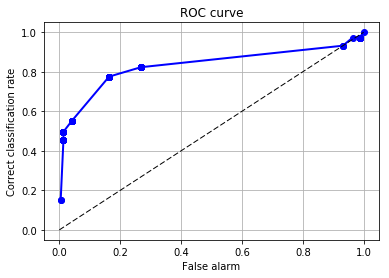

In [53]:
out2 = assess_ROC.to_frame()

plt.plot(1-out2._Specificity_,out2._Sensitivity_,'bo-',linewidth=2)
plt.plot(pd.Series(range(0,11,1))/10,pd.Series(range(0,11,1))/10,'k--',linewidth=1)
#plt.plot(1-out2._Specificity_,1-out2._Specificity_,'k*-',linewidth=2)
plt.xlabel('False alarm')
plt.ylabel('Correct classification rate')
plt.grid(True)
plt.title('ROC curve')
plt.show()

### LIFT chart

In [54]:
out_lift = assess[["_column_", "_depth_","_Cumlift_","_CumliftBest_"]]
out_lift.fetch(to=3)

,_Column_,_Depth_,_CumLift_,_CumLiftBest_
0,P1,10.0,2.408453,2.517007
1,P1,20.0,2.414966,2.517007
2,P1,30.0,2.098639,2.517007


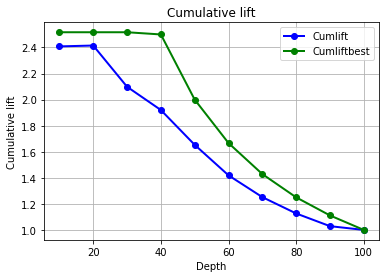

In [56]:
out3 = out_lift.to_frame()

plt.plot(out3._Depth_,out3._CumLift_,'bo-',linewidth=2,label='Cumlift')
plt.plot(out3._Depth_,out3._CumLiftBest_,'go-',linewidth=2,label='Cumliftbest')

plt.xlabel('Depth')
plt.ylabel('Cumulative lift')

plt.grid(True)
plt.title('Cumulative lift')
plt.legend(loc='best', numpoints=1)
plt.show()

## Deploy Model

In [60]:
s.dtreescore(
    table (
        name= 'test_2'
    ),                                              # Table for scoring #
    casout = table(name='dt_score_test',replace=True),   # Table stores the scoring results #
    model  = 'dt_model1',                           # Decison tree model #
    #idvarList = 'PassengerId'                       # Bring the passenger id to the scored results
)

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sasdemo),dt_score_test,418,12,"CASTable('dt_score_test', caslib='CASUSER(sasd..."


In [61]:
stab = s.CASTable('dt_score_test')
stab.head(n=5)

,_DT_PredName_,_DT_PredP_,_DT_PredLevel_,_LeafID_,_MissIt_,_NumNodes_,_NodeList0_,_NodeList1_,_NodeList2_,_NodeList3_,_NodeList4_,_NodeList5_
0,0,0.940171,1.0,21.0,NaN,6.0,0.0,1.0,3.0,8.0,15.0,21.0
1,0,1.000000,1.0,13.0,NaN,4.0,0.0,2.0,6.0,13.0,NaN,NaN
2,0,0.878788,1.0,22.0,NaN,6.0,0.0,1.0,3.0,8.0,15.0,22.0
3,0,0.878788,1.0,22.0,NaN,6.0,0.0,1.0,3.0,8.0,15.0,22.0
4,0,0.515152,1.0,32.0,NaN,6.0,0.0,2.0,6.0,14.0,20.0,32.0


In [77]:
#stab.freq()
s.freq(table(name='dt_score_test',vars='_dt_predname_')) # how the model predicts (0: not survived 1: survived)

,Column,CharVar,FmtVar,Level,Frequency
0,_DT_PredName_,0,0,1,306.0
1,_DT_PredName_,1,1,2,112.0


In [78]:
s.endsession

?.session.Endsession()